In [ ]:
!pip install pyspark

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pyspark


In [ ]:
from pyspark.sql import SparkSession

In [ ]:

# Initialize Spark
spark = SparkSession.builder.appName("EnergyConsumption").getOrCreate()


In [ ]:

historical_data  = spark.read.csv("SM Cleaned Data BR Aggregated.csv", header=True, inferSchema=True)


In [ ]:
historical_data.show()

+-----+----------+------------------+
|meter|      Date|             t_kWh|
+-----+----------+------------------+
| BR02|2019-07-10| 6.959999999999997|
| BR02|2019-07-11| 4.910999999999991|
| BR02|2019-07-13| 5.872999999999988|
| BR02|2019-07-14| 5.457999999999984|
| BR02|2019-07-15| 4.859999999999995|
| BR02|2019-07-16| 4.281999999999985|
| BR02|2019-07-17| 4.421999999999985|
| BR02|2019-07-18|  4.33699999999998|
| BR02|2019-07-19| 5.441999999999984|
| BR02|2019-07-20| 5.650999999999988|
| BR02|2019-07-30| 5.847999999999994|
| BR02|2019-07-31|5.8319999999999865|
| BR02|2019-08-01| 5.006999999999988|
| BR02|2019-08-04| 7.383999999999983|
| BR02|2019-08-05| 6.977999999999994|
| BR02|2019-08-06|5.2839999999999945|
| BR02|2019-08-07| 5.651999999999995|
| BR02|2019-08-08|4.7749999999999835|
| BR02|2019-08-09| 5.005999999999984|
| BR02|2019-08-10|5.8899999999999775|
+-----+----------+------------------+
only showing top 20 rows



In [ ]:
from pyspark.sql.functions import year, month, dayofweek

# Extract year, month, and day of the week as features
historical_data = historical_data.withColumn("Year", year("Date"))
historical_data = historical_data.withColumn("Month", month("Date"))
historical_data = historical_data.withColumn("DayOfWeek", dayofweek("Date"))

# Show the DataFrame with added time-based features
historical_data.show()


+-----+----------+------------------+----+-----+---------+
|meter|      Date|             t_kWh|Year|Month|DayOfWeek|
+-----+----------+------------------+----+-----+---------+
| BR02|2019-07-10| 6.959999999999997|2019|    7|        4|
| BR02|2019-07-11| 4.910999999999991|2019|    7|        5|
| BR02|2019-07-13| 5.872999999999988|2019|    7|        7|
| BR02|2019-07-14| 5.457999999999984|2019|    7|        1|
| BR02|2019-07-15| 4.859999999999995|2019|    7|        2|
| BR02|2019-07-16| 4.281999999999985|2019|    7|        3|
| BR02|2019-07-17| 4.421999999999985|2019|    7|        4|
| BR02|2019-07-18|  4.33699999999998|2019|    7|        5|
| BR02|2019-07-19| 5.441999999999984|2019|    7|        6|
| BR02|2019-07-20| 5.650999999999988|2019|    7|        7|
| BR02|2019-07-30| 5.847999999999994|2019|    7|        3|
| BR02|2019-07-31|5.8319999999999865|2019|    7|        4|
| BR02|2019-08-01| 5.006999999999988|2019|    8|        5|
| BR02|2019-08-04| 7.383999999999983|2019|    8|        

In [ ]:
# Convert the Spark DataFrame to a Pandas DataFrame
historical_pd = historical_data.toPandas()

# Set the Date column as the index
historical_pd['Date'] = pd.to_datetime(historical_pd['Date'])
historical_pd.set_index("Date", inplace=True)

# Extract the target variable
t_kWh = historical_pd['t_kWh']


In [ ]:
def test_stationarity(timeseries):
    # Perform the ADF test
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

# Check stationarity of the target variable
test_stationarity(t_kWh)





ADF Statistic: -10.521281392532694
p-value: 9.668275724474122e-19
Critical Values:
   1%: -3.430583001929187
   5%: -2.8616429802942416
   10%: -2.5668248133133242


In output, the ADF Statistic is -10.521, and the p-value is approximately 9.67e-19. The ADF Statistic value is significantly lower than the critical values at the 1%, 5%, and 10% significance levels. Additionally, the p-value is very close to zero. These results suggest that one can reject the null hypothesis of non-stationarity, indicating that  time series data (t_kWh) is likely stationary.

In [ ]:
from pyspark.sql.functions import year, month, avg
from pyspark.sql.types import DateType
from pyspark.sql.functions import to_date

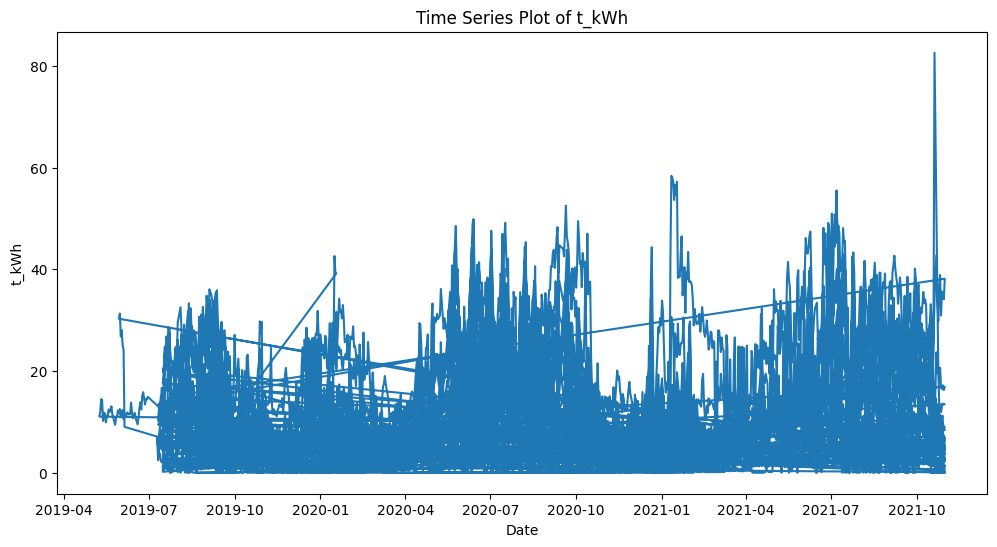

In [ ]:
# Assuming you have a DataFrame named "historical_data" with Date and t_kWh columns
historical_data = historical_data.withColumn("Date", to_date(historical_data["Date"]))

# Collect the data to the driver for plotting (only if data fits in memory)
historical_data_pd = historical_data.toPandas()

# Create a line plot for the time series data
plt.figure(figsize=(12, 6))
plt.plot(historical_data_pd["Date"], historical_data_pd["t_kWh"])
plt.xlabel("Date")
plt.ylabel("t_kWh")
plt.title("Time Series Plot of t_kWh")
plt.show()


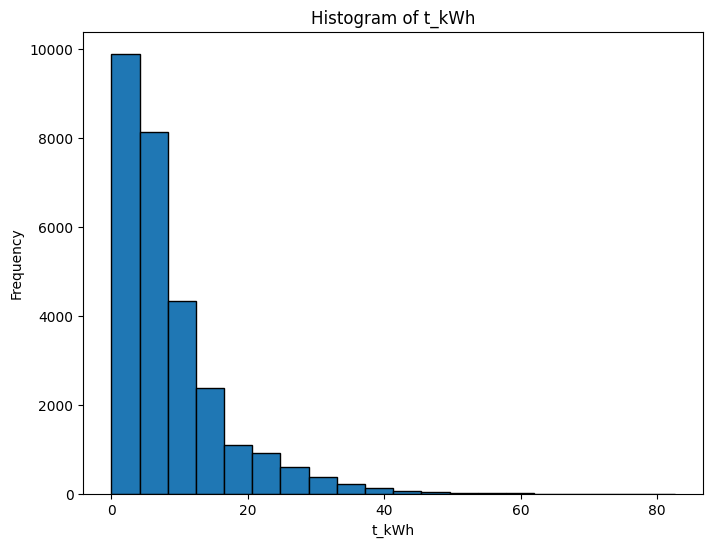

In [ ]:
# Assuming you have a DataFrame named "historical_data" with Date and t_kWh columns
# Collect the data to the driver for plotting (only if data fits in memory)
historical_data_pd = historical_data.toPandas()

# Create a histogram to visualize the distribution of "t_kWh"
plt.figure(figsize=(8, 6))
plt.hist(historical_data_pd["t_kWh"], bins=20, edgecolor="k")
plt.xlabel("t_kWh")
plt.ylabel("Frequency")
plt.title("Histogram of t_kWh")
plt.show()


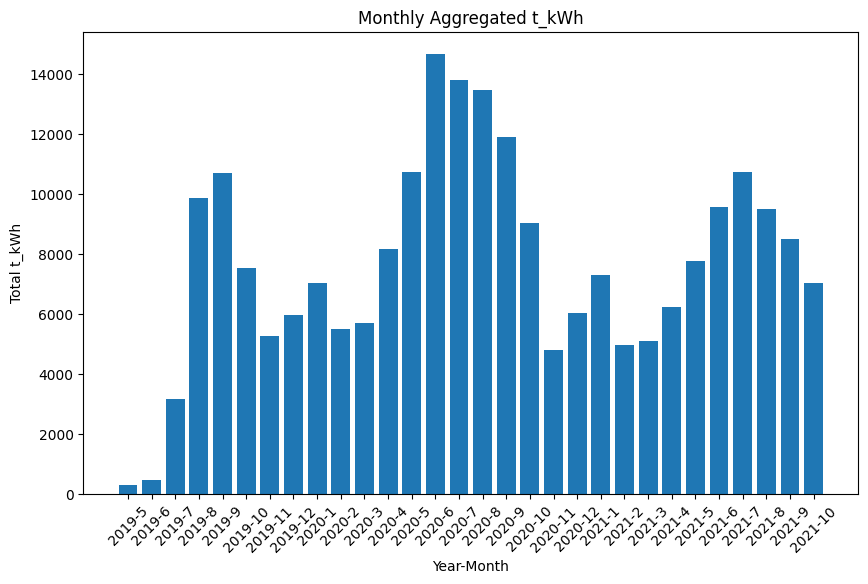

In [ ]:
# Assuming you have a DataFrame named "monthly_data" with Year, Month, and sum(t_kWh) columns
# Collect the data to the driver for plotting (only if data fits in memory)
monthly_data_pd = monthly_data.toPandas()

# Create a bar plot to visualize monthly aggregated data
plt.figure(figsize=(10, 6))
plt.bar(monthly_data_pd["Year"].astype(str) + "-" + monthly_data_pd["Month"].astype(str), monthly_data_pd["sum(t_kWh)"])
plt.xlabel("Year-Month")
plt.ylabel("Total t_kWh")
plt.title("Monthly Aggregated t_kWh")
plt.xticks(rotation=45)
plt.show()


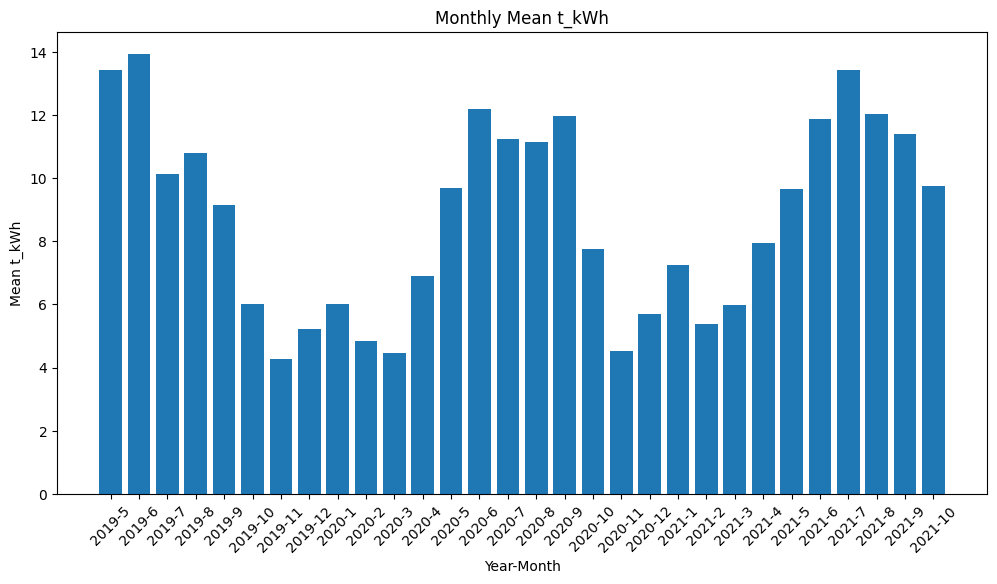

In [ ]:
from pyspark.sql.functions import year, month, avg

# Group the data by year and month and calculate the mean of "t_kWh"
monthly_data = historical_data.groupBy("Year", "Month").agg(avg("t_kWh").alias("Mean_t_kWh")).orderBy("Year", "Month")

# Collect the data to the driver for plotting (only if data fits in memory)
monthly_data_pd = monthly_data.toPandas()

# Create a bar plot to visualize the mean "t_kWh" for each month
plt.figure(figsize=(12, 6))
plt.bar(monthly_data_pd["Year"].astype(str) + "-" + monthly_data_pd["Month"].astype(str), monthly_data_pd["Mean_t_kWh"])
plt.xlabel("Year-Month")
plt.ylabel("Mean t_kWh")
plt.title("Monthly Mean t_kWh")
plt.xticks(rotation=45)
plt.show()


we can observe a seasonal pattern though no strong trend appears to be there

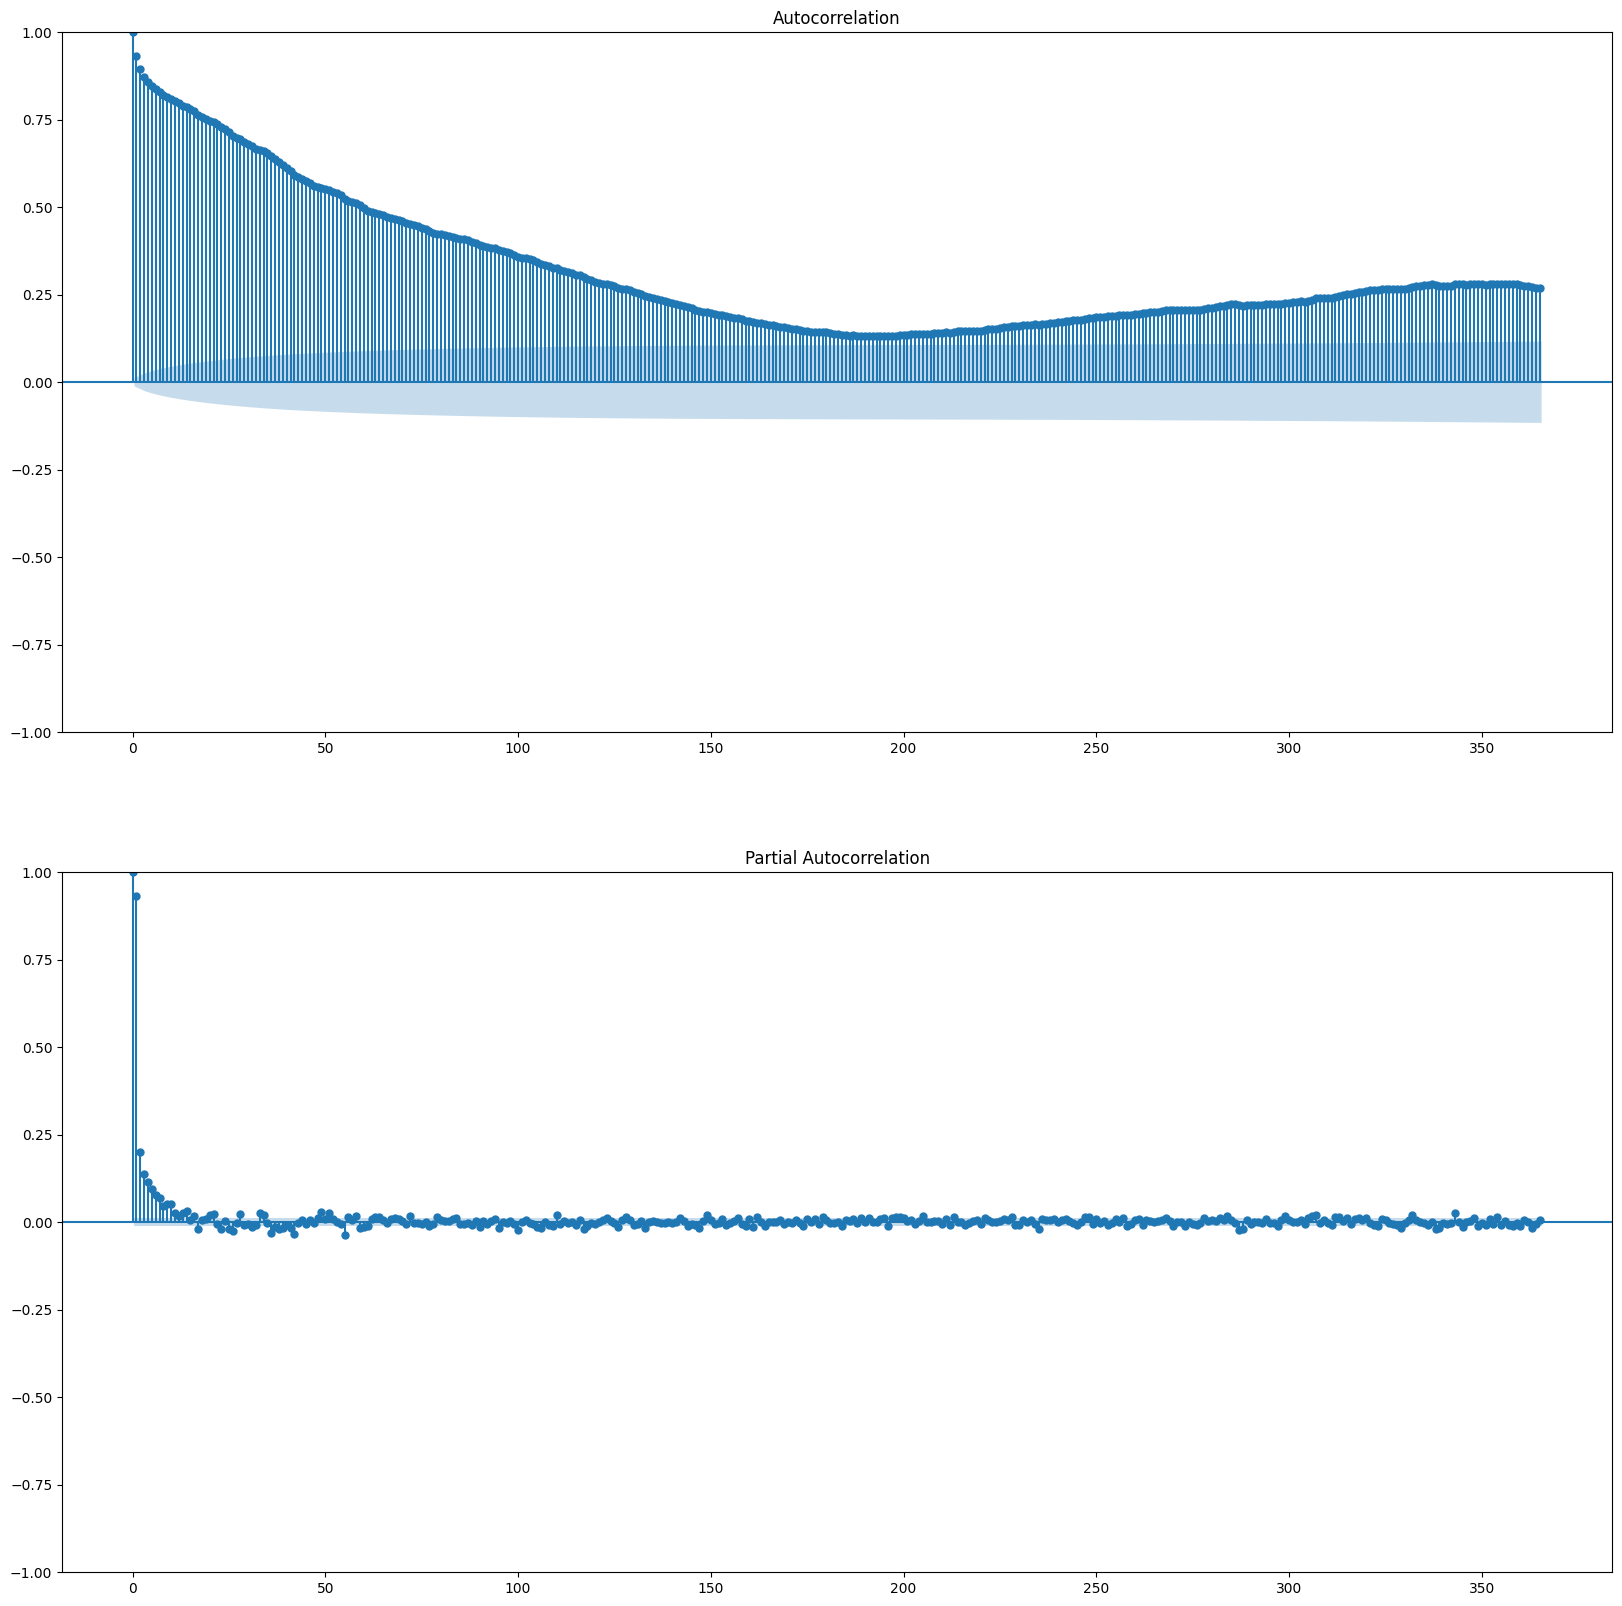

In [ ]:
# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20))
plot_acf(t_kWh, lags=365, ax=ax1)
plot_pacf(t_kWh, lags=365, ax=ax2)
plt.show()


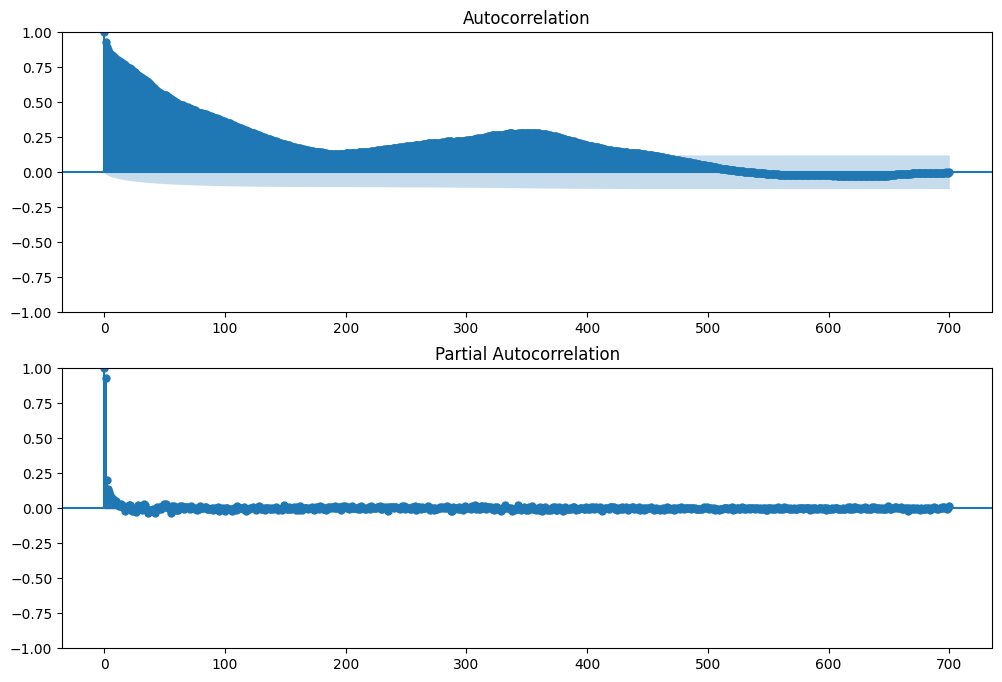

In [ ]:
# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(t_kWh, lags=700, ax=ax1)
plot_pacf(t_kWh, lags=700, ax=ax2)
plt.show()

If you observe strong values in the ACF plot for the first 150 lags and strong values in the PACF plot for about 15 lags, it suggests that your time series may have a seasonal component. To fit a Seasonal Autoregressive Integrated Moving Average (SARIMA) model in this scenario, you'll need to specify both the non-seasonal and seasonal orders.

In [ ]:

from statsmodels.tsa.statespace.sarimax import SARIMAX




In [ ]:
from pyspark.sql.functions import to_date

df  = spark.read.csv("SM Cleaned Data BR Aggregated.csv", header=True, inferSchema=True)


In [ ]:
df.show()

+-----+----------+------------------+
|meter|      Date|             t_kWh|
+-----+----------+------------------+
| BR02|2019-07-10| 6.959999999999997|
| BR02|2019-07-11| 4.910999999999991|
| BR02|2019-07-13| 5.872999999999988|
| BR02|2019-07-14| 5.457999999999984|
| BR02|2019-07-15| 4.859999999999995|
| BR02|2019-07-16| 4.281999999999985|
| BR02|2019-07-17| 4.421999999999985|
| BR02|2019-07-18|  4.33699999999998|
| BR02|2019-07-19| 5.441999999999984|
| BR02|2019-07-20| 5.650999999999988|
| BR02|2019-07-30| 5.847999999999994|
| BR02|2019-07-31|5.8319999999999865|
| BR02|2019-08-01| 5.006999999999988|
| BR02|2019-08-04| 7.383999999999983|
| BR02|2019-08-05| 6.977999999999994|
| BR02|2019-08-06|5.2839999999999945|
| BR02|2019-08-07| 5.651999999999995|
| BR02|2019-08-08|4.7749999999999835|
| BR02|2019-08-09| 5.005999999999984|
| BR02|2019-08-10|5.8899999999999775|
+-----+----------+------------------+
only showing top 20 rows



In [ ]:
df=df['Date', 't_kWh']


In [ ]:
df.show()

+----------+------------------+
|      Date|             t_kWh|
+----------+------------------+
|2019-07-10| 6.959999999999997|
|2019-07-11| 4.910999999999991|
|2019-07-13| 5.872999999999988|
|2019-07-14| 5.457999999999984|
|2019-07-15| 4.859999999999995|
|2019-07-16| 4.281999999999985|
|2019-07-17| 4.421999999999985|
|2019-07-18|  4.33699999999998|
|2019-07-19| 5.441999999999984|
|2019-07-20| 5.650999999999988|
|2019-07-30| 5.847999999999994|
|2019-07-31|5.8319999999999865|
|2019-08-01| 5.006999999999988|
|2019-08-04| 7.383999999999983|
|2019-08-05| 6.977999999999994|
|2019-08-06|5.2839999999999945|
|2019-08-07| 5.651999999999995|
|2019-08-08|4.7749999999999835|
|2019-08-09| 5.005999999999984|
|2019-08-10|5.8899999999999775|
+----------+------------------+
only showing top 20 rows



In [ ]:
df.printSchema()

root
 |-- Date: date (nullable = true)
 |-- t_kWh: double (nullable = true)



In [ ]:
df.summary().show()

+-------+------------------+
|summary|             t_kWh|
+-------+------------------+
|  count|             28119|
|   mean|  8.20758266652449|
| stddev| 7.719020205928047|
|    min|               0.0|
|    25%| 2.920999999999982|
|    50%| 6.015999999999985|
|    75%|11.022000000000007|
|    max| 82.62199999999989|
+-------+------------------+

+-------+------------------+
|summary|             t_kWh|
+-------+------------------+
|  count|             28119|
|   mean|  8.20758266652449|
| stddev| 7.719020205928047|
|    min|               0.0|
|    25%| 2.920999999999982|
|    50%| 6.015999999999985|
|    75%|11.022000000000007|
|    max| 82.62199999999989|
+-------+------------------+



In [ ]:
PandasDF = df.toPandas()